In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from sdtw_div.numba_ops import *

In [1]:
MY_BUCKET = "mon_nom_utilisateur_sspcloud"
CHEMIN_FICHIER = "ensae-reproductibilite/data/raw/data.csv"

# Callable metrics

In [1]:
class SoftDTW():
  def __init__(self, gamma):
    super(SoftDTW, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw(x, y, gamma=self.gamma)

In [ ]:
class SoftDTWValueAndGrad():
  def __init__(self, gamma):
    super(SoftDTWValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw_value_and_grad(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTW():
  def __init__(self, gamma):
    super(SharpSoftDTW, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTWValueAndGrad():
  def __init__(self, gamma):
    super(SharpSoftDTWValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw_value_and_grad(x, y, gamma=self.gamma)

In [ ]:
class SoftDTWDiv():
  def __init__(self, gamma):
    super(SoftDTWDiv, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw_div(x, y, gamma=self.gamma)

In [ ]:
class SoftDTWDivValueAndGrad():
  def __init__(self, gamma):
    super(SoftDTWDivValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw_div_value_and_grad(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTWDiv():
  def __init__(self, gamma):
    super(SharpSoftDTWDiv, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw_div(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTWDivValueAndGrad():
  def __init__(self, gamma):
    super(SharpSoftDTWDivValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw_div_value_and_grad(x, y, gamma=self.gamma)

# Setting up the data

In [6]:
import os
import pandas as pd
import seaborn as sns

In [3]:
# Import the times series through Google drive
# The time series are available at this link https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/

# from google.colab import drive
# drive.mount('/content/drive/')

# data_location = '/content/drive/MyDrive/'
data_dir = '/home/onyxia/work/SoftDTWForEcon/UCRArchive_2018'

In [7]:
df = pd.read_csv("../DS_ICA_CSV_FR/DS_ICA_data.csv",sep=";", encoding="utf-8")
print(df.columns)
df["TIME_PERIOD"] = pd.to_datetime(df["TIME_PERIOD"], format="%Y-%m")
colonne = df.columns[0]
df_activity = df[(df[colonne] == "L") & (df["SEASONAL_ADJUST"] == "Y")&(df["IDX_TYPE"]=="ICA_SERV")].sort_values(by="TIME_PERIOD", ascending=True)
df_activity_2016 = df_activity[df_activity["TIME_PERIOD"].dt.year == 2012]
print(df_activity_2016)
print(df_activity)

Index(['ACTIVITY', 'SEASONAL_ADJUST', 'IDX_TYPE', 'BASE_PER', 'OBS_STATUS',
       'OBS_STATUS_FR', 'UNIT_MEASURE', 'DECIMALS', 'FREQ', 'MARCHE',
       'CONF_STATUS', 'INDICATOR', 'EMBARGO_DATE', 'TIME_PERIOD', 'OBS_VALUE'],
      dtype='object')
       ACTIVITY SEASONAL_ADJUST  IDX_TYPE  BASE_PER OBS_STATUS OBS_STATUS_FR  \
782335        L               Y  ICA_SERV      2021          R             D   
675520        L               Y  ICA_SERV      2021          R             D   
632402        L               Y  ICA_SERV      2021          A             D   
268838        L               Y  ICA_SERV      2021          A             D   
782334        L               Y  ICA_SERV      2021          A             D   
675519        L               Y  ICA_SERV      2021          R             D   
675513        L               Y  ICA_SERV      2021          R             D   
782286        L               Y  ICA_SERV      2021          R             D   
675511        L               Y 

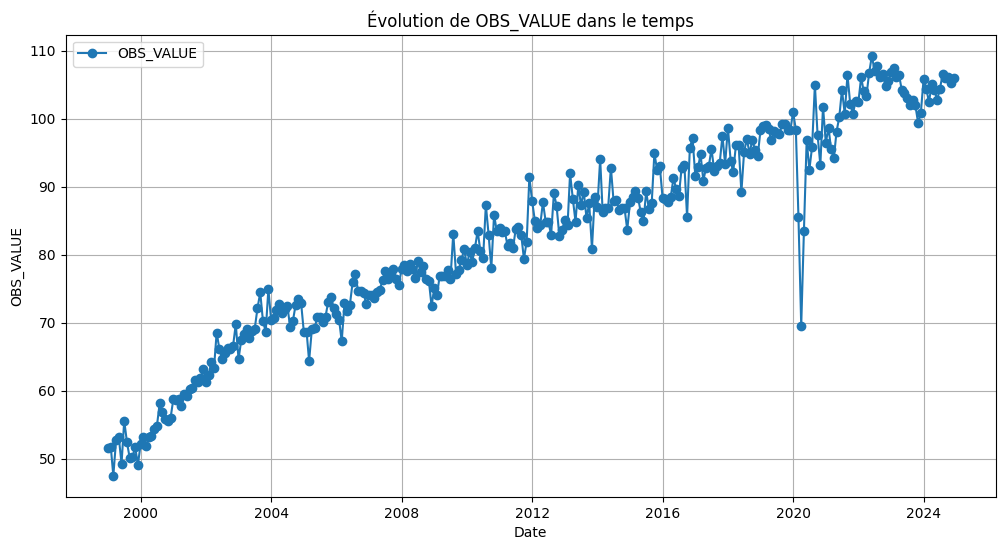

In [8]:
plt.figure(figsize=(12, 6))  # Définir la taille du graphique
plt.plot(df_activity["TIME_PERIOD"], df_activity["OBS_VALUE"],marker='o', label="OBS_VALUE")  
plt.xlabel("Date")
plt.ylabel("OBS_VALUE")
plt.title("Évolution de OBS_VALUE dans le temps")
plt.grid()
plt.legend()
plt.show()

In [9]:
input_size = 20
output_size = 5
def create_time_series_window(values,input_size=20,output_size=5):
        X=[]
        y=[]
        for i in range(len(values) - input_size - output_size):

                X.append(values[i:i + input_size])  
                y.append(values[i + input_size:i + input_size + output_size])  
        return np.array(X), np.array(y)

In [4]:
# Create training and test sets

catgs = os.listdir(data_dir)
# remove Missing_value_and_variable_length_datasets_adjusted from catgs
catgs.remove('Missing_value_and_variable_length_datasets_adjusted')
catgs_missing = os.listdir(data_dir + '/Missing_value_and_variable_length_datasets_adjusted')
catgs_missing.remove('REAME.md')
catgs_missing.remove('missing_value_and_variable_length_datasets_info.csv')
trainings = []
tests = []

for folder in catgs:
  file = pd.read_csv(data_dir + '/' + folder + '/' + folder + '_TRAIN.tsv', sep='\t', header=None)
  trainings.append(file)
  file = pd.read_csv(data_dir + '/' + folder + '/' + folder + '_TEST.tsv', sep='\t', header=None)
  tests.append(file)

In [33]:
tests[0]

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,1,-1.125013,-1.131338,-1.138288,-1.146687,-1.138639,-1.141431,-1.143691,-1.144379,-1.154912,...,-1.205572,-1.281235,-1.323420,-1.345800,-1.344547,-1.301098,-1.265903,-1.212717,-1.206178,-1.218422
1,2,-0.626956,-0.625919,-0.627538,-0.626326,-0.624085,-0.624708,-0.625006,-0.624175,-0.624018,...,-0.620019,-0.621505,-0.621526,-0.624091,-0.623989,-0.624350,-0.624376,-0.619471,-0.612058,-0.606422
2,2,-2.001163,-1.999575,-1.999537,-1.999196,-1.999004,-2.000315,-1.998425,-2.000679,-1.999995,...,0.312798,0.242217,0.145716,0.014012,-0.151780,-0.333427,-0.577435,-0.812720,-1.071147,-1.323383
3,1,-1.004587,-0.999843,-0.995250,-0.992019,-0.991200,-0.987556,-0.996473,-0.996878,-0.998673,...,-1.080245,-1.060166,-1.044471,-1.039528,-1.040693,-1.044162,-1.044058,-1.044916,-1.044226,-1.043262
4,1,-0.742625,-0.743770,-0.743900,-0.744873,-0.744745,-0.745364,-0.747078,-0.746615,-0.746705,...,-0.699312,-0.696897,-0.694059,-0.689150,-0.687534,-0.682798,-0.682153,-0.681030,-0.670519,-0.657403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2,-0.580006,-0.583332,-0.586108,-0.589118,-0.591951,-0.599196,-0.609292,-0.618504,-0.627164,...,-0.536779,-0.537708,-0.537554,-0.538319,-0.538915,-0.541542,-0.545838,-0.546621,-0.548831,-0.553552
146,1,-0.728153,-0.730242,-0.733560,-0.734188,-0.734331,-0.734660,-0.733856,-0.733397,-0.732929,...,-0.788042,-0.768710,-0.748156,-0.728561,-0.711126,-0.699604,-0.689584,-0.687476,-0.686448,-0.690183
147,2,-0.738012,-0.736301,-0.731226,-0.728455,-0.728883,-0.727372,-0.724525,-0.720916,-0.719828,...,-0.617504,-0.613856,-0.611590,-0.609785,-0.609814,-0.608848,-0.610023,-0.609646,-0.608616,-0.612177
148,2,-1.265111,-1.256093,-1.259421,-1.256351,-1.253265,-1.260103,-1.265063,-1.256396,-1.246350,...,-1.192413,-1.193333,-1.195697,-1.189598,-1.177099,-1.188014,-1.189629,-1.199970,-1.193374,-1.192835


In [32]:
trainings[0]

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,2,-0.647885,-0.641992,-0.638186,-0.638259,-0.638345,-0.638697,-0.643049,-0.643768,-0.645050,...,-0.639264,-0.639716,-0.639735,-0.640184,-0.639235,-0.639395,-0.640231,-0.640429,-0.638666,-0.638657
1,2,-0.644427,-0.645401,-0.647055,-0.647492,-0.646910,-0.643884,-0.639731,-0.638094,-0.635297,...,-0.641140,-0.641426,-0.639267,-0.637797,-0.637680,-0.635260,-0.635490,-0.634934,-0.634497,-0.631596
2,1,-0.778353,-0.778279,-0.777151,-0.777684,-0.775900,-0.772421,-0.765464,-0.762275,-0.763752,...,-0.722055,-0.718712,-0.713534,-0.710021,-0.704126,-0.703263,-0.703393,-0.704196,-0.707605,-0.707120
3,1,-0.750060,-0.748103,-0.746164,-0.745926,-0.743767,-0.743805,-0.745213,-0.745082,-0.745727,...,-0.721667,-0.724661,-0.729229,-0.728940,-0.727834,-0.728244,-0.726453,-0.725517,-0.725191,-0.724679
4,2,-0.599539,-0.597422,-0.599269,-0.598259,-0.597582,-0.591303,-0.589020,-0.587533,-0.585462,...,-0.644036,-0.643885,-0.645742,-0.646458,-0.646464,-0.645585,-0.642412,-0.643337,-0.636803,-0.631716
5,2,-0.547736,-0.553660,-0.557194,-0.559599,-0.564312,-0.568220,-0.571968,-0.575826,-0.577354,...,-0.706939,-0.704759,-0.703900,-0.704163,-0.705410,-0.705741,-0.703861,-0.706541,-0.710381,-0.710854
6,2,-1.261183,-1.294884,-1.310105,-1.319604,-1.320262,-1.317001,-1.309626,-1.296729,-1.284765,...,-1.260114,-1.269225,-1.274458,-1.278982,-1.280090,-1.281349,-1.281277,-1.280616,-1.280212,-1.279940
7,2,-2.012581,-2.012069,-2.011625,-2.013534,-2.013438,-2.013219,-2.014245,-2.012278,-2.014058,...,0.426970,0.360089,0.274340,0.163402,0.019592,-0.150113,-0.333859,-0.551477,-0.782467,-1.007992
8,2,-1.065573,-1.066501,-1.067219,-1.068197,-1.067617,-1.071252,-1.067488,-1.067816,-1.067875,...,-1.051603,-1.046511,-1.048871,-1.046295,-1.046580,-1.038032,-1.037612,-1.033426,-1.031462,-1.030165
9,1,-1.177206,-1.175839,-1.173185,-1.170890,-1.169488,-1.166309,-1.165919,-1.167642,-1.166901,...,-1.225565,-1.295701,-1.327421,-1.327071,-1.300439,-1.271138,-1.267283,-1.265006,-1.270722,-1.262134


In [5]:
idxs = []
for i, cat in enumerate(catgs):
  # if trainings[i].shape[1] > 100 and trainings[i].shape[0] > 100 and tests[i].shape[0] > 400: #sufficient data size and samples
  print(i, cat)
  idxs.append(i)

0 GunPoint
1 AllGestureWiimoteZ
2 ShakeGestureWiimoteZ
3 ProximalPhalanxTW
4 ACSF1
5 DiatomSizeReduction
6 Mallat
7 Chinatown
8 SmoothSubspace
9 LargeKitchenAppliances
10 UWaveGestureLibraryY
11 Trace
12 FordB
13 ECG5000
14 SonyAIBORobotSurface2
15 BME
16 Earthquakes
17 UWaveGestureLibraryZ
18 MiddlePhalanxTW
19 TwoPatterns
20 PLAID
21 Yoga
22 PowerCons
23 Fungi
24 Worms
25 GestureMidAirD2
26 CBF
27 Wafer
28 HouseTwenty
29 Lightning7
30 StarLightCurves
31 ElectricDevices
32 PigArtPressure
33 CricketX
34 PigCVP
35 FreezerSmallTrain
36 GunPointMaleVersusFemale
37 InsectEPGRegularTrain
38 SyntheticControl
39 UWaveGestureLibraryX
40 ChlorineConcentration
41 FordA
42 ECG200
43 SwedishLeaf
44 HandOutlines
45 FaceFour
46 OliveOil
47 Strawberry
48 Car
49 Coffee
50 Computers
51 Beef
52 DodgerLoopDay
53 ECGFiveDays
54 ToeSegmentation2
55 DistalPhalanxTW
56 FiftyWords
57 GunPointOldVersusYoung
58 MixedShapesRegularTrain
59 ScreenType
60 EOGVerticalSignal
61 MiddlePhalanxOutlineAgeGroup
62 GunPoin

# Data preprocessing

In [6]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import scipy as sp


/home/onyxia/work/SoftDTWForEcon/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [7]:
# Missing values detection

idxs = [116, 119, 99, 80, 22, 16]

# Here we look at which time series have missing values

for i in idxs:
  if trainings[i].isna().values.any():
      print(catgs[i] + " has " + str(trainings[i].isna().values.sum()) + " missing values in trainings")
      trainings[i].interpolate(method='linear', inplace=True)
  else:
      print(catgs[i] + " has no missing values in trainings")

  if tests[i].isna().values.any():
      print(catgs[i] + " has " + str(tests[i].isna().values.sum()) + " missing values in tests")
      tests[i].interpolate(method='linear', inplace=True)
  else:
      print(catgs[i] + " has no missing values in tests")
  print("--------------------------------")


AllGestureWiimoteX has 112527 missing values in trainings
AllGestureWiimoteX has 262736 missing values in tests
--------------------------------
Plane has no missing values in trainings
Plane has no missing values in tests
--------------------------------
PickupGestureWiimoteZ has 10756 missing values in trainings
PickupGestureWiimoteZ has 10773 missing values in tests
--------------------------------
MoteStrain has no missing values in trainings
MoteStrain has no missing values in tests
--------------------------------
PowerCons has no missing values in trainings
PowerCons has no missing values in tests
--------------------------------
Earthquakes has no missing values in trainings
Earthquakes has no missing values in tests
--------------------------------


In [8]:
# Checking for outliers

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

def outlier_detection(data):
  quantile_threshold_low, quantile_threshold_high = 0.01, 0.997

  fig, ax = fig_ax()
  _ = ax.hist(data, 20)

  threshold_low, threshold_high = np.quantile(
      data, [quantile_threshold_low, quantile_threshold_high]
  )

  _ = ax.axvline(threshold_low, ls="--", color="k")
  _ = ax.axvline(threshold_high, ls="--", color="k")

  fig, ax = fig_ax()
  ax.plot(data, "*-")

  outlier_mask = (data < threshold_low) | (
      data > threshold_high
  )

  ax.plot(
      data[outlier_mask],
      "*",
      label="Outliers",
  )

  plt.legend()

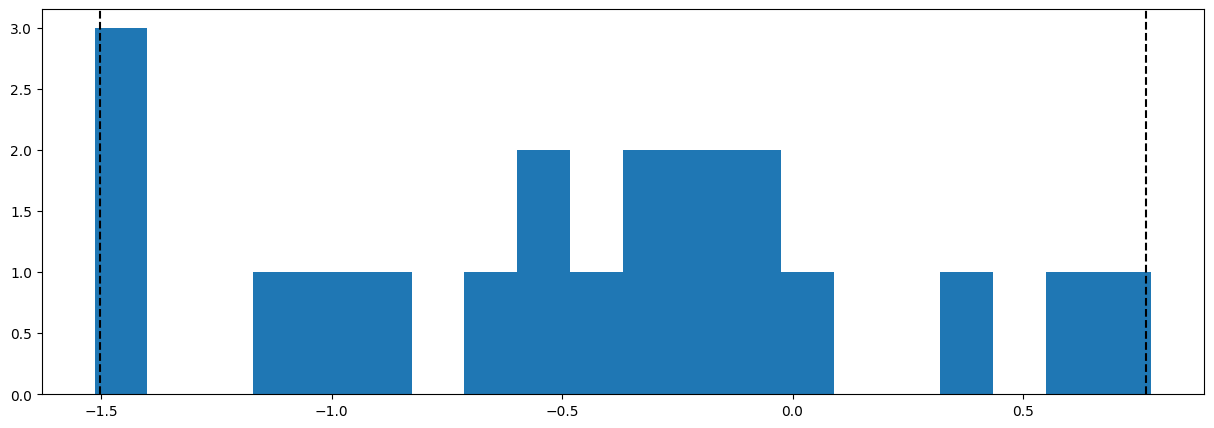

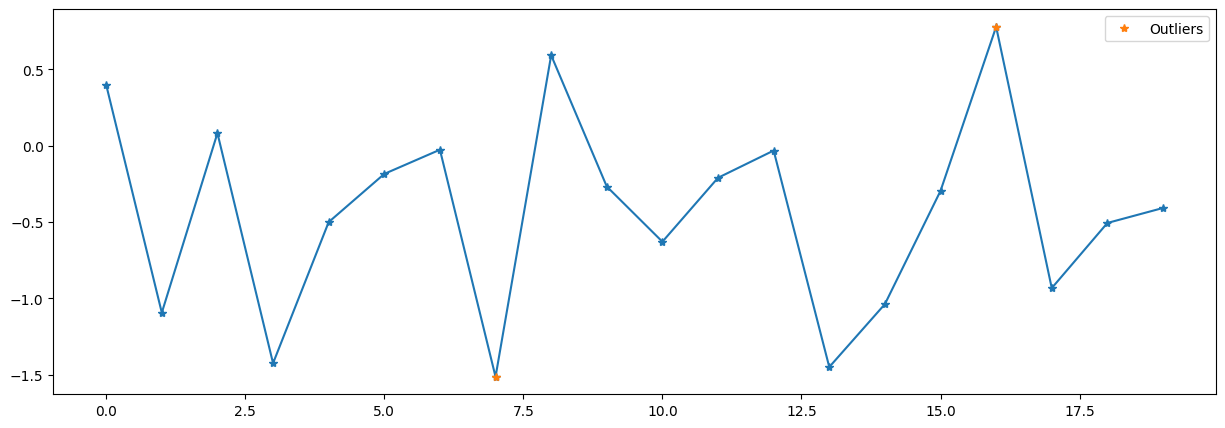

In [9]:
outlier_detection(trainings[80][1])

# Time series averaging

Experimental setup:
- in the original paper: DTW, SDTW, SHARP, MEANCOST with Euclidean mean initialization and $\gamma = 1$. Divergences with their "biased counterpart" as initialization and $\gamma = 10$.
- here: all discrepancies are computed with $\gamma$ in $\{0.01, 0.1, 1, 10, 100\}$. We keep the same initializations as in the original paper.

In [ ]:
from scipy.optimize import minimize
from tslearn.barycenters import *

In [ ]:
idxs = [116, 119, 99, 80, 22, 16]

In [ ]:
# DTW barycenters
# We use the DBA algorithm to compute the barycenters

dtw_barycenters = []

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0) # we average on 10 samples from the dataset
  print("DTW barycenters on the " + catgs[i] + " dataset")
  b = dtw_barycenter_averaging(trainings_array[i][:10], init_barycenter=eucl_mean, max_iter=200)
  dtw_barycenters.append(b)
  plt.plot(b, linewidth=2)
  for j in range(10):
    plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
  plt.title("DTW")
  plt.show()

In [ ]:
import pickle

In [ ]:
with open('dtw_barycenters.pickle', 'wb') as fp:
    pickle.dump(dtw_barycenters, fp)

In [ ]:
gammas = [0.01, 0.1, 1., 10., 100.]

In [ ]:
# SoftDTW barycenters

sdtw_barycenters = [[], [], [], [], []]

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0)
  print("Soft-DTW barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SoftDTWValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=eucl_mean, value_and_grad=func)
    sdtw_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.07, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Soft-DTW")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sdtw_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sdtw_barycenters.pickle', 'wb') as fp:
    pickle.dump(sdtw_barycenters, fp)

In [ ]:
# Sharp barycenters

sharp_barycenters = [[], [], [], [], []]

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0)
  print("Sharp barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SharpSoftDTWValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=eucl_mean, value_and_grad=func)
    sharp_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Sharp")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sharp_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sharp_barycenters.pickle', 'wb') as fp:
    pickle.dump(sharp_barycenters, fp)

In [ ]:
# Mean-cost barycenters

mean_cost_barycenters = []

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0)
  print("Mean-cost barycenters on the " + catgs[i] + " dataset")
  b = barycenter(trainings_array[i][:10], X_init=eucl_mean, value_and_grad=mean_cost_value_and_grad)
  mean_cost_barycenters.append(b)
  plt.plot(b, linewidth=2)
  for j in range(10):
    plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
  plt.title("Mean-cost")
  plt.show()

In [ ]:
with open('mean_cost_barycenters.pickle', 'wb') as fp:
    pickle.dump(mean_cost_barycenters, fp)

In [ ]:
# Soft-DTW divergence

sdtw_div_barycenters = [[], [], [], [], []]

for idx, i in enumerate(idxs):
  print("Soft-DTW divergence barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SoftDTWDivValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=sdtw_barycenters[g][idx], value_and_grad=func)
    sdtw_div_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Soft-DTW divergence")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sdtw_div_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sdtw_div_barycenters.pickle', 'wb') as fp:
    pickle.dump(sdtw_div_barycenters, fp)

In [ ]:
# Sharp divergence

sharp_div_barycenters = [[], [], [], [], []]

for idx, i in enumerate(idxs):
  print("Sharp divergence barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SharpSoftDTWDivValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=sharp_barycenters[g][idx], value_and_grad=func)
    sharp_div_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Sharp divergence")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sharp_div_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sharp_div_barycenters.pickle', 'wb') as fp:
    pickle.dump(sharp_div_barycenters, fp)

In [ ]:
# Mean-cost divergence

mean_cost_div_barycenters = []

for idx, i in enumerate(idxs):
  print("Mean-cost divergence barycenters on the " + catgs[i] + " dataset")
  b = barycenter(trainings_array[i][:10], X_init=mean_cost_barycenters[idx], value_and_grad=mean_cost_div_value_and_grad)
  mean_cost_div_barycenters.append(b)
  plt.plot(b, linewidth=2)
  for j in range(10):
    plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
  plt.title("Mean-cost divergence")
  plt.show()

In [ ]:
with open('mean_cost_div_barycenters.pickle', 'wb') as fp:
    pickle.dump(mean_cost_div_barycenters, fp)

### Quantitative results

In [ ]:
from tslearn.metrics import dtw

In [ ]:
for idx, i in enumerate(idxs):
  print("distances for dataset " + catgs[i])
  to_avg = trainings_array[i][:10]
  dtw_dists = np.zeros((len(to_avg), 1))
  sdtw_dists = np.zeros((len(to_avg), len(gammas)))
  sharp_dists = np.zeros((len(to_avg), len(gammas)))
  mean_cost_dists = np.zeros((len(to_avg), 1))
  sdtw_div_dists = np.zeros((len(to_avg), len(gammas)))
  sharp_div_dists = np.zeros((len(to_avg), len(gammas)))
  mean_cost_div_dists = np.zeros((len(to_avg), 1))
  for s_idx, s in enumerate(to_avg):
    dtw_dists[s_idx] = dtw(dtw_barycenters[idx], s)
    mean_cost_dists[s_idx] = dtw(mean_cost_barycenters[idx], s)
    mean_cost_div_dists[s_idx] = dtw(mean_cost_div_barycenters[idx], s)
    for g_idx, g in enumerate(gammas):
      sdtw_dists[s_idx][g_idx] = dtw(sdtw_barycenters[g_idx][idx], s)
      sharp_dists[s_idx][g_idx] = dtw(sharp_barycenters[g_idx][idx], s)
      sdtw_div_dists[s_idx][g_idx] = dtw(sdtw_div_barycenters[g_idx][idx], s)
      sharp_div_dists[s_idx][g_idx] = dtw(sharp_div_barycenters[g_idx][idx], s)
  dtw_dist = np.mean(dtw_dists, axis=0)
  sdtw_dist = np.mean(sdtw_dists, axis=0)
  sharp_dist = np.mean(sharp_dists, axis=0)
  mean_cost_dist = np.mean(mean_cost_dists, axis=0)
  mean_cost_div_dist = np.mean(mean_cost_div_dists, axis=0)
  sdtw_div_dist = np.mean(sdtw_div_dists, axis=0)
  sharp_div_dist = np.mean(sharp_div_dists, axis=0)
  print("dtw: ", (dtw_dist))
  print("sdtw: ", (sdtw_dist))
  print("sharp: ", (sharp_dist))
  print("mean_cost: ", (mean_cost_dist))
  print("mean_cost_div: ", (mean_cost_div_dist))
  print("sdtw_div: ", (sdtw_div_dist))
  print("sharp_div: ", (sharp_div_dist))
  print("-------")

# Time series clustering

We apply the various discrepancies presented in the paper to a task unexamined by the authors: clustering time series with the K-means algorithm.

Experimental setup:
- downsample time series to length 40
- number of clusters equal to the number of classes in the data
- gammas from $1e-4$ to $100$
- max_iter for K-means equal to 30, max_iter for barycenter computation equal to 100
- random initialization

Qualitative comparisons: smoothness of clusters learned

Quantitative comparisons: DTW distance from the cluster center to the time series for each cluster

### Utilities

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
def make_data(i, samples=100, sz=40):
  X = TimeSeriesResampler(sz=sz).fit_transform(trainings_array[i][:samples])
  return X

In [ ]:
def plot(X, y, n_clusters, km_object, sz=40, title=None, savefig=None):
  for yi in range(n_clusters):
    plt.subplot(n_clusters//2+1, 2, 1+yi)
    for xx in X[y == yi]:
      plt.plot(xx.squeeze(axis=-1), "k-", alpha=.2)
    plt.plot(km_object.centroids[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))
  plt.tight_layout()
  if title is not None:
    plt.suptitle(title, y=1.05, size=16)
  plt.show()
  if savefig is not None:
    plt.savefig(savefig)

In [ ]:
# implement the K-means algorithm

class KMeans():

  def __init__(self, metric, n_clusters, init=None, max_iter_outer=100, max_iter_inner=30, tol=1e-5):

    self.n_clusters = n_clusters
    self.max_iter_outer = max_iter_outer
    self.max_iter_inner = max_iter_inner
    self.metric = metric
    self.init = init
    self.tol = tol

  def fit(self, X_train):

    if self.init is None: # Random initialization for the centroids
      self.centroids = [X_train[np.random.choice(range(len(X_train)))] for _ in range(self.n_clusters)]
    else:
      self.centroids = self.init

    # Iterate, adjusting centroids until inertia has converged or until passed max_iter
    iteration = 0
    prev_centroids = None
    diff_inertias = np.inf
    prev_inertia = np.inf
    while diff_inertias > self.tol and iteration < self.max_iter_outer:
      # Sort each datapoint, assigning to nearest centroid
      sorted_points = [[self.centroids[i]] for i in range(self.n_clusters)] # each cluster contains at least its centroid
      for x in X_train:
        if self.metric == "dtw_":
          dists = np.array([dtw(x, centroid) for centroid in self.centroids])
        else:
          dists = np.array([self.metric(x, centroid)[0] for centroid in self.centroids])
        centroid_idx = np.argmin(dists)
        sorted_points[centroid_idx].append(x)
      # Update centroids
      prev_centroids = self.centroids
      if self.metric == "dtw_":
        self.centroids = [dtw_barycenter_averaging(cluster, init_barycenter = np.mean(cluster, axis=0), max_iter=self.max_iter_inner) for cluster in sorted_points]
      else:
        self.centroids = [barycenter(cluster, X_init=np.mean(cluster, axis=0), value_and_grad=self.metric, max_iter=self.max_iter_inner) for cluster in sorted_points]
      for i, centroid in enumerate(self.centroids):
        if np.isnan(centroid).any():  # Catch any np.nans, resulting from an empty centroid
          self.centroids[i] = prev_centroids[i]
      # Compute mean inertia (distance to the nearest centroid)
      inertia = 0
      for i, centroid in enumerate(self.centroids):
        inertia_cluster = 0
        for x in sorted_points[i]:
          if self.metric == "dtw_":
            inertia_cluster += dtw(x, centroid)
          else:
            inertia_cluster += self.metric(x, centroid)[0]
        inertia_cluster /= len(sorted_points[i])
        inertia += inertia_cluster
      inertia /= self.n_clusters
      diff_inertias = np.abs(inertia - prev_inertia)
      prev_inertia = inertia
      iteration += 1

  def evaluate(self, X):

    centroids = []
    centroid_idxs = []
    for x in X:
      if self.metric == "dtw_":
        dists = np.array([dtw(x, centroid) for centroid in self.centroids])
      else:
        dists = np.array([self.metric(x, centroid)[0] for centroid in self.centroids])
      centroid_idx = np.argmin(dists)
      centroids.append(self.centroids[centroid_idx])
      centroid_idxs.append(centroid_idx)
    return centroids, centroid_idxs

### Experiments

In [ ]:
gammas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [ ]:
idxs = [116, 119, 99, 80, 22, 16]

#### DTW

In [ ]:
km_dtw = []

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  metric = "dtw_"
  nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
  km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
  km.fit(X)
  km_dtw.append(km)
  centroids, centroid_idxs = km.evaluate(X)
  plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="DTW", savefig='/content/drive/MyDrive/plots time series project/' + 'KM_DTW_' + catgs[i] + '.png')

print("-------")

In [ ]:
print("DTW:")
km_dtw_dists = np.zeros((1, len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  centroids, centroid_idxs = km_dtw[0].evaluate(X)
  dists = []
  for c, centroid in enumerate(centroids):
    xx = X[np.array(centroid_idxs) == c]
    if len(xx) != 0:
      dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
  km_dtw_dists[0, idx] = np.mean(dists) # mean among the clusters

In [ ]:
print(np.round(km_dtw_dists, 2))

#### SoftDTW

In [ ]:
km_sdtw = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SoftDTWValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sdtw[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="SDTW, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_SDTW_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
# compute mean DTW distance of time series to centroid for each cluster

print("SoftDTW:")

km_sdtw_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sdtw[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sdtw_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sdtw_dists[g, :], 2))

#### Sharp

In [ ]:
km_sharp = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SharpSoftDTWValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sharp[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Sharp, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Sharp_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Sharp:")
km_sharp_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sharp[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sharp_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sharp_dists[g, :], 2))

#### Sharp div

In [ ]:
km_sharp_div = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SharpSoftDTWDivValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sharp_div[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Sharp DIV, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Sharp_Div_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Sharp Div:")
km_sharp_div_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sharp_div[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sharp_div_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sharp_div_dists[g, :], 2))

#### Mean Cost

In [ ]:
km_mean_cost = []

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  metric = mean_cost_value_and_grad
  nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
  km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
  km.fit(X)
  km_mean_cost.append(km)
  centroids, centroid_idxs = km.evaluate(X)
  plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Mean cost", savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Meancost_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Mean Cost:")
km_meancost_dists = np.zeros((1, len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  centroids, centroid_idxs = km_mean_cost[0].evaluate(X)
  dists = []
  for c, centroid in enumerate(centroids):
    xx = X[np.array(centroid_idxs) == c]
    if len(xx) != 0:
      dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
  km_meancost_dists[0, idx] = np.mean(dists) # mean among the clusters

In [ ]:
print(np.round(km_meancost_dists, 2))

#### Mean Cost Div

In [ ]:
km_mean_cost_div = []

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  metric = mean_cost_div_value_and_grad
  nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
  km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
  km.fit(X)
  km_mean_cost_div.append(km)
  centroids, centroid_idxs = km.evaluate(X)
  plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Mean cost DIV", savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Meancost_Div_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Mean Cost Div:")
km_meancost_div_dists = np.zeros((1, len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  centroids, centroid_idxs = km_mean_cost_div[0].evaluate(X)
  dists = []
  for c, centroid in enumerate(centroids):
    xx = X[np.array(centroid_idxs) == c]
    if len(xx) != 0:
      dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
  km_meancost_div_dists[0, idx] = np.mean(dists) # mean among the clusters

In [ ]:
print(np.round(km_meancost_div_dists, 2))

#### SoftDTW Div

In [ ]:
km_sdtw_div = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SoftDTWDivValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sdtw_div[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="SDTW Div, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_SDTW_Div_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("SoftDTW Div:")
km_sdtw_div_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sdtw_div[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sdtw_div_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sdtw_div_dists[g, :], 2))

# Time series forecasting

We use the Soft DTW divergence as a loss function for a neural network in order to study its performance in comparison to the Soft DTW and the Mean Squared Error.

Experimental setup:
- For each dataset, we train 3  groups of models:
  - Soft DTW for $\gamma\in \{0.01, 0.1, 1,10,100\}$
  - Soft DTW Div for $\gamma\in \{0.01, 0.1, 1,10,100\}$
  - Mean Squared Error (only one model in this group)
- We use 60% of the dataset to predict the next 40%


Qualitatively, we plot the obtained predictions and compare them to the ground truth.

Quantitavively, we compute the DTW distance and the MSE between the predictions and the ground truth.

## Utilities

In [10]:
# Build MLP for time series prediction.
from tslearn.metrics import SoftDTWLossPyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):

    if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)

    batch_size = x.size(0)
    x_reshaped = torch.reshape(x, (batch_size, -1))  # Manipulations to deal with time series format
    output = F.sigmoid(self.fc1(x_reshaped))
    output = self.fc2(output)
    return torch.reshape(output, (batch_size, -1, 1))  # Manipulations to deal with time series format

/home/onyxia/work/SoftDTWForEcon/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [11]:
def train_models(cat, trainings, hidden_size=300, epochs=150, batch_size=50, lr=1e-2, gammas=[1e-2, 1e-1, 1, 10, 100], max_norm=100.,divergence=True):

  i = cat

  X_train = np.array(trainings[i])[:, 1:]
  input_size = int(X_train.shape[1]*0.6)
  output_size = X_train.shape[1] - input_size

  x = torch.Tensor(X_train[:, :input_size]).unsqueeze(-1)
  x = (x - x.mean(dim=0))/x.std(dim=0)
  y = torch.Tensor(X_train[:, input_size:]).unsqueeze(-1)
  y = (y - y.mean(dim=0))/y.std(dim=0)

  X_val = np.array(tests[i])[:, 1:]
  x_val = torch.Tensor(X_val[:, :input_size]).unsqueeze(-1)
  x_val = (x_val - x_val.mean(dim=0))/x_val.std(dim=0)
  x_val=x_val.to(device)
  y_val = torch.Tensor(X_val[:, input_size:]).unsqueeze(-1)
  y_val = (y_val - y_val.mean(dim=0))/y_val.std(dim=0)
  y_val=y_val.to(device)

  models = []
  for gamma in gammas:

    model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    loss_fn = SoftDTWLossPyTorch(gamma=gamma, normalize=divergence).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # task: predict next values given the first 60% of values

    losses = []

    for epoch in range(epochs):
      shuffled_idxs = torch.randperm(x.size(0))
      for batch_idx in range(0, x.size(0), batch_size):
      # select batch
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = x[idxs].to(device)
        y_batch = y[idxs].to(device)
        pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        # validation loss
        pred = model(x_val)
        val_loss = loss_fn(pred, y_val).mean()
        print("Epoch: {}, Train loss: {}, Validation loss: {}".format(epoch, loss, val_loss))

    plt.plot(np.array(losses))
    plt.title("gamma = {}".format(gamma))
    plt.show()

    models.append(model)

  # add model with MSE loss

  model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
  loss_fn = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  losses = []

  for epoch in range(epochs):
      shuffled_idxs = torch.randperm(x.size(0))
      for batch_idx in range(0, x.size(0), batch_size):
      # select batch
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = x[idxs].to(device)
        y_batch = y[idxs].to(device)
        pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, loss))

  plt.plot(np.array(losses))
  plt.title("MSE")
  plt.show()

  models.append(model)

  return models

In [12]:
def train_test_split(df,value,split_train,input_size,output_size):
    values = df[value].values
    split_idx = int(len(values)*split_train)
    train_data,test_data=values[:split_idx],values[split_idx:]
    X_train,y_train = create_time_series_window(train_data,input_size,output_size)
    X_test,y_test=create_time_series_window(test_data,input_size,output_size)
    return X_train,y_train,X_test,y_test

In [13]:
X_train,y_train,X_test,y_test=train_test_split(df_activity,"OBS_VALUE",0.6,input_size,output_size)    
print(X_train)
print(y_train)

[[51.54 51.69 47.52 ... 54.39 54.83 58.15]
 [51.69 47.52 52.75 ... 54.83 58.15 56.9 ]
 [47.52 52.75 53.21 ... 58.15 56.9  55.86]
 ...
 [84.38 87.73 84.86 ... 85.39 87.54 80.88]
 [87.73 84.86 84.75 ... 87.54 80.88 88.43]
 [84.86 84.75 82.97 ... 80.88 88.43 87.06]]
[[56.9  55.86 55.63 56.02 58.77]
 [55.86 55.63 56.02 58.77 58.65]
 [55.63 56.02 58.77 58.65 58.82]
 [56.02 58.77 58.65 58.82 57.79]
 [58.77 58.65 58.82 57.79 59.58]
 [58.65 58.82 57.79 59.58 59.27]
 [58.82 57.79 59.58 59.27 60.21]
 [57.79 59.58 59.27 60.21 60.37]
 [59.58 59.27 60.21 60.37 61.53]
 [59.27 60.21 60.37 61.53 61.26]
 [60.21 60.37 61.53 61.26 61.82]
 [60.37 61.53 61.26 61.82 63.17]
 [61.53 61.26 61.82 63.17 61.3 ]
 [61.26 61.82 63.17 61.3  62.29]
 [61.82 63.17 61.3  62.29 64.25]
 [63.17 61.3  62.29 64.25 63.31]
 [61.3  62.29 64.25 63.31 68.55]
 [62.29 64.25 63.31 68.55 66.12]
 [64.25 63.31 68.55 66.12 64.66]
 [63.31 68.55 66.12 64.66 65.55]
 [68.55 66.12 64.66 65.55 66.27]
 [66.12 64.66 65.55 66.27 66.12]
 [64.66 65

In [14]:
def train_models_insee(value,df, hidden_size=300, epochs=150, batch_size=50, lr=1e-2, gammas=[1e-2, 1e-1, 1, 10, 100], max_norm=100.,divergence=True):


  X_train,y_train,X_test,y_test=train_test_split(df,value,0.6,input_size,output_size)    

  x = torch.Tensor(np.array(X_train)).unsqueeze(-1)
  x = (x - x.mean(dim=0))/x.std(dim=0)
  y = torch.Tensor(np.array(y_train)).unsqueeze(-1)
  y = (y - y.mean(dim=0))/y.std(dim=0)

  X_val =x[-120:].to(device)
  y_val =y[-120:].to(device)
  X_tensor=x[:-120]
  Y_tensor=y[:-120]
  
 


  models = []
  for gamma in gammas:

    model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    loss_fn = SoftDTWLossPyTorch(gamma=gamma, normalize=divergence).to(device)
    #loss_fn = SoftDTWLoss(gamma=gamma)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # task: predict next values given the first 60% of values

    losses = []

    for epoch in range(epochs):
      shuffled_idxs = torch.randperm(X_tensor.size(0))
      for batch_idx in range(0, X_tensor.size(0), batch_size):
      # select batch
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = X_tensor[idxs].to(device)
        y_batch = Y_tensor[idxs].to(device)
        pred = model(x_batch).to(device)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        # validation loss
        pred = model(X_val).to(device)
        val_loss = loss_fn(pred, y_val).mean()
        print("Epoch: {}, Train loss: {}, Validation loss: {}".format(epoch, loss, val_loss))
        

    plt.plot(np.array(losses))
    plt.title("gamma = {}".format(gamma))
    plt.show()

    models.append(model)

  # add model with MSE loss

  model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
  loss_fn = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  losses = []

  for epoch in range(epochs):

      shuffled_idxs = torch.randperm(X_tensor.size(0))
      for batch_idx in range(0, X_tensor.size(0), batch_size):
      # select batch
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = X_tensor[idxs].to(device)
        y_batch = Y_tensor[idxs].to(device)
        pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, loss))

  plt.plot(np.array(losses))
  plt.title("MSE")
  plt.show()

  models.append(model)

  return models

In [39]:
def eval_models_insee(models,value,df,input_size=20,output_size=5):
  X_train,y_train,X_test,y_test = train_test_split(df,value,0.6,input_size,output_size)
  x_test = torch.Tensor(np.array(X_test)).unsqueeze(-1).to(device)
  x_test = (x_test - x_test.mean(dim=0))/x_test.std(dim=0)
  input_size = int(x_test.shape[1])
  print(input_size)
  res = []
  for m in range(len(models)):
    result = models[m](x_test)
    print(result.shape)
    res.append(result)
  return res

In [16]:
def eval_models(models, cat, testings):  
  X_test = np.array(testings[cat])[:, 1:]
  input_size = int(X_test.shape[1]*0.6)
  res = []
  for m in range(len(models)):
    result = models[m](torch.Tensor(X_test[:, :input_size]).unsqueeze(-1)).detach().numpy().squeeze()
    # result = result * X_test[:, input_size:].std(1).reshape(-1, 1) + X_test[:, input_size:].mean(1).reshape(-1, 1)
    res.append(result)
  return res

In [49]:
import seaborn as sns

def plot_forecasts_insee(res, value,df,gammas,input_size=20,output_size=5):
  X_train,y_train,X_test,y_test = train_test_split(df,value,0.6,input_size,output_size)
  X_test = np.array(X_test)
  input_size = int(X_test.shape[1])
  output_size = int(y_test.shape[1])


  X_val = (X_test - X_test.mean(axis=0))/X_test.std(axis=0)
  y_test= (y_test-y_test.mean(axis=0))/y_test.std(axis=0)
  gt = X_test
  print(gt.shape)
  print(X_test.shape[0])
  for i in range(0, 10):
    for m in range(len(res)):
      color = sns.color_palette("magma")[m%6]
      if m < len(res)-1:
        #plt.plot(np.arange(input_size), gt[i],color='grey', label='Ground truth')
        plt.plot(np.arange(input_size,input_size+output_size), y_test[i],color='grey', label='Ground truth')
        plt.plot(np.arange(input_size, input_size + output_size), res[m][i].cpu().detach().squeeze(-1), color='red', label='$\gamma$ = {}'.format(gammas[m]), alpha=0.6)
        #plt.plot(np.arange(input_size, input_size + output_size), res[-1][i].cpu().detach().squeeze(-1),color='green', label='MSE', alpha=0.6)
        plt.axvline(x = input_size, linestyle = 'dashed', color = 'k')
        plt.title("{}".format(gammas[m]))
        plt.legend()
        plt.grid()
        plt.show()
      else:
        #plt.plot(np.arange(input_size, input_size + output_size), res[m][i].cpu().detach().squeeze(-1),color='green', label='MSE', alpha=0.6)
       # plt.axvline(x = input_size, linestyle = 'dashed', color = 'k')
       # plt.grid()

        plt.title("{}".format(i))
        plt.legend()
        plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3427/938507474.py:21: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(np.arange(input_size, input_size + output_size), res[m][i].cpu().detach().squeeze(-1), color='red', label='$\gamma$ = {}'.format(gammas[m]), alpha=0.6)


In [ ]:
import seaborn as sns

def plot_forecasts(res, cat, test,gammas):
  input_size = int(np.array(test[cat])[:,1:].shape[1]*0.6)
  output_size = test[cat].shape[1]- input_size

  X_val = np.array(test[cat])[:, 1:]
  X_val = (X_val - X_val.mean(axis=0))/X_val.std(axis=0)
  gt = X_val
  print(gt.shape)
  print(test[cat].shape[0])
  for i in range(0, 10):
    for m in range(len(res)):
      color = sns.color_palette("magma")[m%6]
      if m < len(res)-1:
        plo11##t.plot(np.arange(input_size + output_size - 1), gt[i],color='grey', label='Ground truth')
        plt.plot(np.arange(input_size, input_size + output_size -1), res[m][i], color='red', label='$\gamma$ = {}'.format(gammas[m]), alpha=0.6)
        plt.plot(np.arange(input_size, input_size + output_size -1), res[-1][i],color='green', label='MSE', alpha=0.6)
        plt.axvline(x = input_size, linestyle = 'dashed', color = 'k')
        plt.title("{}".format(gammas[m]))
        plt.legend()
        plt.grid()
        plt.show()
      else:
        plt.plot(np.arange(input_size, input_size + output_size -1), res[m][i],color='green', label='MSE', alpha=0.6)
        plt.axvline(x = input_size, linestyle = 'dashed', color = 'k')
        plt.grid()

        plt.title("{}".format(i))
        plt.legend()
        plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3427/3924303964.py:17: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(np.arange(input_size, input_size + output_size -1), res[m][i], color='red', label='$\gamma$ = {}'.format(gammas[m]), alpha=0.6)


In [56]:
from tslearn.metrics import soft_dtw, SoftDTWLossPyTorch, dtw


def error(res, cat, test):
  input_size = int(np.array(test[cat])[:,1:].shape[1]*0.6)
  gt = np.array(test[cat])[:, 1:][np.newaxis, :, input_size:]
  gt = (gt - gt.mean(axis=1, keepdims=True))/gt.std(axis=1, keepdims=True)
  res = np.array(res)

  # MSE
  mse = np.mean((gt - res)**2, axis=2)
  std_mse = np.std(mse, axis=1)
  mse = np.mean(mse, axis=1)

  # DTW
  dtw_models = np.zeros((len(res), gt.shape[1]))
  for m in range(len(res)):
    for ts in range(gt.shape[1]):
      dist = dtw(gt[0, ts], res[m][ts])
      dtw_models[m][ts] = dist
  std_dtw = np.std(dtw_models, axis=1)
  dtws = np.mean(dtw_models, axis=1)
  print("For " + catgs[cat])
  print("MSE: {} +- {}".format(np.round(mse,2), np.round(std_mse,2)))
  print("DTW: {} +- {}".format(np.round(dtws,2), np.round(std_dtw,2)))

In [86]:
from tslearn.metrics import soft_dtw, SoftDTWLossPyTorch, dtw


def error_insee(res, value,df,input_size=20,output_size=5):
  X_train,y_train,X_test,y_test = train_test_split(df,value,0.6,input_size,output_size)
  y_test = np.array(y_test)
  input_size = int(y_test.shape[1])
  output_size = int(y_test.shape[1])
  gt = y_test
  gt = (gt - gt.mean(axis=1, keepdims=True))/gt.std(axis=1, keepdims=True)
  res = np.array([r.cpu().detach().numpy() if isinstance(r, torch.Tensor) else r for r in res])


  # MSE
  mse = np.mean((gt - res[0].squeeze(-1))**2, axis=1)
  std_mse = np.std((gt - res[0].squeeze(-1))**2)
  mse = np.mean(mse)

  # DTW
  dtw_models = np.zeros((len(res), gt.shape[1]))
  for m in range(len(res)):
    for ts in range(gt.shape[1]):
      dist = dtw(gt[0, ts], res[m][ts])
      dtw_models[m][ts] = dist
  std_dtw = np.std(dtw_models, axis=1)
  dtws = np.mean(dtw_models, axis=1)
  print("MSE: {} +- {}".format(np.round(mse,2), np.round(std_mse,2)))
  print("DTW: {} +- {}".format(np.round(dtws,2), np.round(std_dtw,2)))

## Experiments

In [20]:
#Indexes of the categories you wish to study
# idxs = [116, 119, 22, 16]
idxs = [116]

#Values of gamma you wish to study
gammas = [1]

### Soft DTW Loss

In [ ]:
forecast_models=[]
for i in idxs:
  forecast_models.append(train_models(i, trainings, gammas=gammas,divergence=False))

# This cell takes a while to run depending on the number of datasets that you train on

In [ ]:
models = train_models_insee("OBS_VALUE",df_activity, gammas=gammas,divergence=False)

In [40]:

results = eval_models_insee(models,"OBS_VALUE",df_activity)
print(len(results[0]))

20
torch.Size([100, 5, 1])
torch.Size([100, 5, 1])
100


In [87]:
#plot_forecasts_insee(results, "OBS_VALUE",df_activity,gammas)
error_insee(results, "OBS_VALUE",df_activity)

MSE: 1.82 +- 2.29
DTW: [2.48 2.52] +- [2.2  2.19]


In [ ]:
for i in range(len(idxs)):
  plot_forecasts(results[i], idxs[i], tests,gammas)
  error(results[i], idxs[i], tests)

### Soft DTW Divergence Loss

In [ ]:
forecast_models=[]
for i in idxs:
  forecast_models.append(train_models(i, trainings, gammas=gammas, divergence=True))

In [ ]:
results=[]
for i,idx in enumerate(idxs):
  results.append(eval_models(forecast_models[i],idx,tests))

In [ ]:
for i in range(len(idxs)):
  plot_forecasts(results[i], idxs[i], tests,gammas)
  error(results[i], idxs[i], tests)